In [1]:
from mesa import Agent, Model
from mesa.space import MultiGrid
import random

class SIRAgent(Agent):
    def __init__(self, unique_id, model, status="S", vaccinated=False):
        super().__init__(model)  # bara model!
        self.unique_id = unique_id  # sätt unik ID själv
        self.status = status        # "S", "I", "R", "D"
        self.vaccinated = vaccinated
        self.days_infected = 0

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True, # kan gå diagonalt 
            include_center=False # kan inte stanna kvar på samma ställe 
        )
        new_position = self.random.choice(possible_steps) # random steg 
        self.model.grid.move_agent(self, new_position) # uppdaterar position

    def try_infect(self, other):
        if other.status == "S":
            if other.vaccinated:
                # Vaccinerade har 5% risk att bli smittade
                infection_chance = 0.03
            else:
                infection_chance = 1.0
                
            if self.random.random() < infection_chance:
                other.status = "I" ## Detta leder till att alla som är icke vaccinerade blir sjuka, detta behöver vi ändra

    def step(self):
        if self.status == "D":
            return  # döda rör sig inte eller smittar

        self.move()

        if self.status == "I":
            # Smitta andra i samma cell
            cellmates = self.model.grid.get_cell_list_contents([self.pos])
            for other in cellmates:
                if other != self:
                    self.try_infect(other)

            # Öka dagar sjuk
            self.days_infected += 1

            # Dödsrisk
            if self.random.random() < self.model.mortality_rate:
                self.status = "D"
                return

            # Återhämtning efter 10 dagar
            if self.days_infected >= 10:
                self.status = "R"

class SIRModel(Model):
    def __init__(self, N, width, height, initial_infected=1, vaccination_rate=0.0, mortality_rate=0.01):
        super().__init__()
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.mortality_rate = mortality_rate

        # Agentlista (inte self.agents)
        self.agent_list = []

        for i in range(N):
            vaccinated = self.random.random() < vaccination_rate
            if i < initial_infected:
                status = "I"
            elif vaccinated:
                status = "R"  # Vaccinerade räknas som immun
            else:
                status = "S"

            agent = SIRAgent(i, self, status=status, vaccinated=vaccinated)
            self.agent_list.append(agent)

            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))

    def step(self):
        self.random.shuffle(self.agent_list)
        for agent in self.agent_list:
            agent.step()

    # Funktion för att räkna antal agenter med viss status
    def count_status(self, status):
        return sum(1 for a in self.agent_list if a.status == status)


# --------------------------
# EXEMPEL: köra modellen
# --------------------------

N = 100
width = 10
height = 10
initial_infected = 5
vaccination_rate = 0.2
mortality_rate = 0.01
timesteps = 1000

model = SIRModel(N, width, height, initial_infected, vaccination_rate, mortality_rate)

for t in range(timesteps):
    model.step()

# Skriv ut resultat efter 1000 steg
print("S:", model.count_status("S"))
print("I:", model.count_status("I"))
print("R:", model.count_status("R"))
print("D:", model.count_status("D"))


S: 0
I: 0
R: 94
D: 6


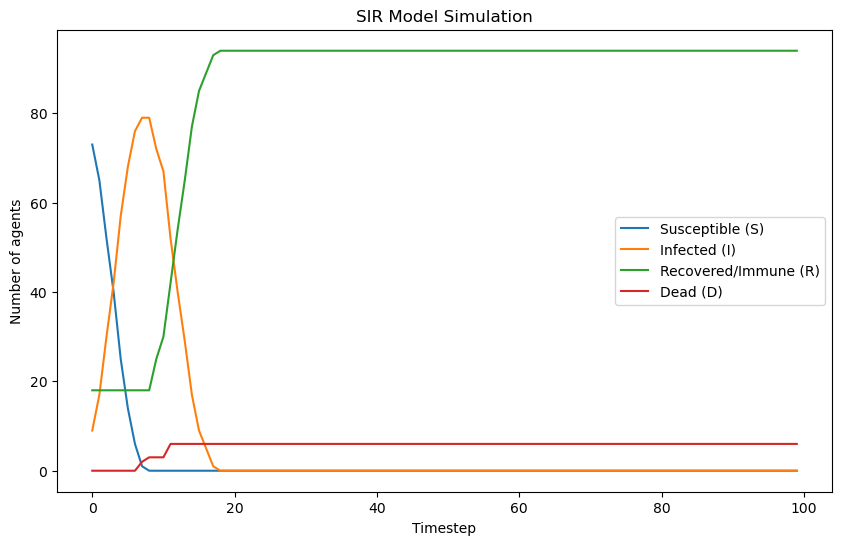

In [2]:
import matplotlib.pyplot as plt

# --------------------------
# PARAMETRAR
# --------------------------
N = 100
width = 10
height = 10
initial_infected = 5
vaccination_rate = 0.2
mortality_rate = 0.01
timesteps = 100

# --------------------------
# SKAPA MODELL
# --------------------------
model = SIRModel(N, width, height, initial_infected, vaccination_rate, mortality_rate)

# --------------------------
# LISTOR FÖR DATA
# --------------------------
S_history = []
I_history = []
R_history = []
D_history = []

# --------------------------
# KÖR MODELLEN
# --------------------------
for t in range(timesteps):
    model.step()
    S_history.append(model.count_status("S"))
    I_history.append(model.count_status("I"))
    R_history.append(model.count_status("R"))
    D_history.append(model.count_status("D"))

# --------------------------
# RITA GRAF
# --------------------------
plt.figure(figsize=(10,6))
plt.plot(S_history, label="Susceptible (S)")
plt.plot(I_history, label="Infected (I)")
plt.plot(R_history, label="Recovered/Immune (R)")
plt.plot(D_history, label="Dead (D)")
plt.xlabel("Timestep")
plt.ylabel("Number of agents")
plt.title("SIR Model Simulation")
plt.legend()
plt.show()
